In [31]:
import tensorflow as tf
import tensorflowjs as tfjs
from tensorflow import keras
import numpy as np
import json
import math
import inspect
import matplotlib.pyplot as plt
import pandas as pd

In [32]:
def get_color_labels_dict():
    return {
        "red-ish": 0,
        "green-ish": 1,
        "blue-ish": 2,
        "orange-ish": 3,
        "yellow-ish": 4,
        "pink-ish": 5,
        "purple-ish": 6,
        "brown-ish": 7,
        "gray-ish": 8,
    }

target_names = np.array(list(get_color_labels_dict().keys()))

def get_target_name(index):
    return target_names[index]

def encode_color_labels_as_int(labels):
    labels_dict = get_color_labels_dict()
    
    return list(map(lambda label: labels_dict[label], labels))

def get_rgb_values(color):
    rgb_array = [color['red'], color['green'], color['blue']]
    return rgb_array

def get_color_label(color):
    return color["label"]

def load_json():
    path = "./data/labeled-colors-2020.json"

    with open(path) as json_file:
        json_str = json_file.read()

    return json.loads(json_str)

def prep_data(data):
    rgb_list = list(map(get_rgb_values, data))
    labels_as_string = list(map(get_color_label, data))
    labels_as_int = encode_color_labels_as_int(labels_as_string)
    
    rgb_ndarray = np.array(rgb_list)
    labels_ndarray = np.array(labels_as_int)
    
    return (rgb_ndarray, labels_ndarray)

def load_data():
    colors_array = load_json()
    prepped_data = prep_data(colors_array)
    return prepped_data

# Plot a grid of individual colors from the dataset
# The colors won’t be labeled
# I tried using annotate to label the colors, but positioning the labels was tedious
def plot_colors(one_hundred_colors):
    plt.figure(figsize=(12, 12), facecolor="black", tight_layout=True)
    # We reshape the colors into a square, so we need to know the size of the passed argument ahead of time...
    # That’s why it’s called one_hundred_colors
    plt.imshow(one_hundred_colors.reshape(10, 10, 3))
    plt.axis("off")
    plt.annotate('Test', xy=(0.9, 0.0), xycoords="axes fraction")
    
# Plot a bunch of colors from the dataset, and their labels
def plot_train_data(X, y, start=0, count=24):
    max_count = min(count, X.shape[0])
    
    n_cols = 8
    n_rows = math.ceil(max_count / n_cols)
    plt.figure(figsize=(n_cols * 2, n_rows * 2))
    for row in range(n_rows):
        for col in range(n_cols):
            index = n_cols * row + col
            
            # Stop plotting if you reached the desired count
            if (index == max_count):
                return
            
            plt.subplot(n_rows, n_cols, index + 1)
            
#             breakpoint()
            data_index = start + index
            
            color = X[data_index, :]
            color = color[np.newaxis, :]
            color = color.reshape(1, 1, 3)
            
            target_name = get_target_name(y[data_index])
            
            plt.imshow(color)
            plt.axis('off')
            plt.title(target_name, fontsize=12)
    plt.subplots_adjust(wspace=0.2, hspace=0.5)
    plt.show()
    
def shuffle(array):
    rng = np.random.default_rng()
    array_copy = array.copy()
    return rng.shuffle(array_copy)

def split_train_test_valid(data, test_size=0.3, valid_size=0.1):
    total_count = data.shape[0]
    
    test_count = math.floor(total_count * test_size)
    valid_count = math.floor(total_count * valid_size)
    train_count = total_count - test_count - valid_count
    
    train = data[:train_count, :]
    
    valid_start_index = train_count
    valid_end_index = valid_start_index + valid_count
    valid = data[valid_start_index:valid_end_index, :]
    
    test_start_index = valid_end_index
    test = data[test_start_index:, :]
    
    return (train, valid, test)

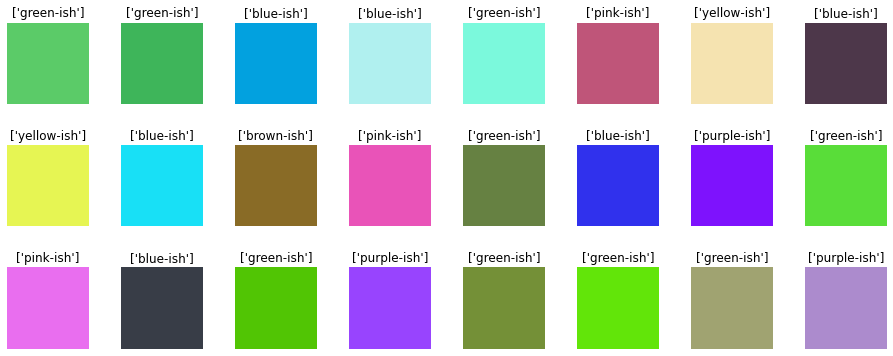

In [33]:
plot_train_data(X_valid, y_valid, start=0)

In [34]:
X, y = load_data()

np.save("./data/data_X", X, allow_pickle=True)
np.save("./data/data_y", y, allow_pickle=True)

X_train, X_valid, X_test = split_train_test_valid(X)
y_train, y_valid, y_test = split_train_test_valid(y[:, np.newaxis])
print(X_train.shape, X_valid.shape, X_test.shape)
print(y_train.shape, y_valid.shape, y_test.shape)

(1212, 3) (202, 3) (606, 3)
(1212, 1) (202, 1) (606, 1)


In [35]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [36]:
model = keras.models.Sequential([
    keras.layers.Dense(300, activation="relu", input_shape=[3]),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(9, activation="softmax")
])

In [37]:
model.layers

In [38]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 300)               1200      
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 9)                 909       
Total params: 32,209
Trainable params: 32,209
Non-trainable params: 0
_________________________________________________________________


In [39]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

In [40]:
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))

Epoch 1/30
38/38 [==============================] - 0s 4ms/step - loss: 10.2809 - accuracy: 0.6040 - val_loss: 0.8083 - val_accuracy: 0.6782
Epoch 2/30
38/38 [==============================] - 0s 2ms/step - loss: 0.7448 - accuracy: 0.7376 - val_loss: 0.7150 - val_accuracy: 0.6931
Epoch 3/30
38/38 [==============================] - 0s 2ms/step - loss: 0.7150 - accuracy: 0.7467 - val_loss: 0.6908 - val_accuracy: 0.7277
Epoch 4/30
38/38 [==============================] - 0s 2ms/step - loss: 0.6434 - accuracy: 0.7583 - val_loss: 0.6826 - val_accuracy: 0.7228
Epoch 5/30
38/38 [==============================] - 0s 1ms/step - loss: 0.6153 - accuracy: 0.7616 - val_loss: 0.7740 - val_accuracy: 0.6832
Epoch 6/30
38/38 [==============================] - 0s 1ms/step - loss: 0.5912 - accuracy: 0.7748 - val_loss: 0.5932 - val_accuracy: 0.7574
Epoch 7/30
38/38 [==============================] - 0s 1ms/step - loss: 0.5640 - accuracy: 0.7731 - val_loss: 0.6694 - val_accuracy: 0.7426
Epoch 8/30
38/38 [=

In [41]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 38}

In [42]:
history.history

{'loss': [10.280924797058105,
  0.7447540760040283,
  0.715042233467102,
  0.6433671712875366,
  0.6152715086936951,
  0.5912188291549683,
  0.5639628171920776,
  0.5483373999595642,
  0.5240954160690308,
  0.5388662219047546,
  0.5473572015762329,
  0.5171023607254028,
  0.5171857476234436,
  0.49347683787345886,
  0.5117508172988892,
  0.5225411653518677,
  0.5017150640487671,
  0.5026771426200867,
  0.5116164684295654,
  0.481865257024765,
  0.47904571890830994,
  0.4794655442237854,
  0.49303433299064636,
  0.4794459640979767,
  0.5015237927436829,
  0.4916447401046753,
  0.4609028398990631,
  0.4598771333694458,
  0.4636530578136444,
  0.4709482192993164],
 'accuracy': [0.603960394859314,
  0.7376237511634827,
  0.7466996908187866,
  0.7582508325576782,
  0.7615511417388916,
  0.7747524976730347,
  0.7731022834777832,
  0.778052806854248,
  0.7854785323143005,
  0.778052806854248,
  0.7772276997566223,
  0.7904290556907654,
  0.7945544719696045,
  0.8028053045272827,
  0.774752497

In [43]:
model.evaluate(X_test, y_test)

19/19 [==============================] - 0s 2ms/step - loss: 0.5543 - accuracy: 0.7657


[0.5542805790901184, 0.7656765580177307]

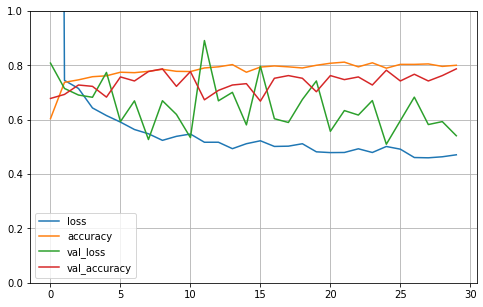

In [44]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [45]:
X_new = X_test[:30]
y_proba = model.predict(X_new)
y_proba.round(2)

array([[0.  , 0.  , 0.01, 0.  , 0.  , 0.04, 0.95, 0.  , 0.  ],
       [0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.42, 0.58, 0.  , 0.  ],
       [0.98, 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.  , 0.  ],
       [0.03, 0.  , 0.  , 0.64, 0.  , 0.  , 0.  , 0.33, 0.  ],
       [0.  , 0.02, 0.77, 0.  , 0.  , 0.  , 0.21, 0.  , 0.  ],
       [0.  , 0.93, 0.05, 0.  , 0.  , 0.  , 0.  , 0.  , 0.01],
       [0.  , 0.27, 0.73, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.01, 0.  , 0.  , 0.07, 0.91, 0.  , 0.  ],
       [0.  , 0.99, 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.11, 0.89, 0.  , 0.  ],
       [0.  , 0.33, 0.04, 0.02, 0.  , 0.05, 0.01, 0.01, 0.53],
       [0.  , 0.  , 0.03, 0.  , 0.  , 0.01, 0.97, 0.  , 0.  ],
       [0.  , 0.  , 0.03, 0.  , 0.  , 0.08, 0.89, 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,

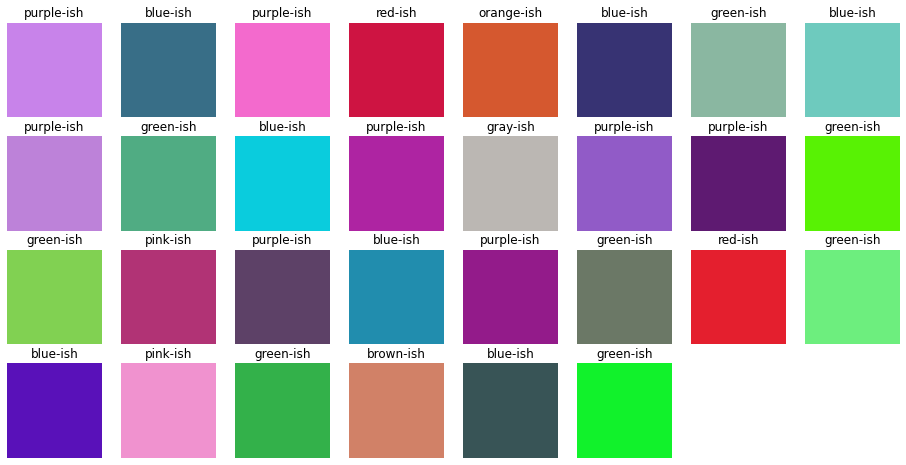

In [46]:
y_indexes = np.argmax(y_proba, axis=1)
plot_train_data(X_new, y_indexes, start=0, count=30)

In [47]:
print(inspect.getdoc(tfjs.converters.save_keras_model))

Save a Keras model and its weights in TensorFlow.js format.

Args:
  model: An instance of `keras.Model`.
  artifacts_dir: The directory in which the artifacts will be saved.
    The artifacts to be saved include:
      - model.json: A JSON representing the model. It has the following
        fields:
        - 'modelTopology': A JSON object describing the topology of the model,
          along with additional information such as training. It is obtained
          through calling `model.save()`.
        - 'weightsManifest': A TensorFlow.js-format JSON manifest for the
          model's weights.
      - files containing weight values in groups, with the file name pattern
        group(\d+)-shard(\d+)of(\d+).
    If the directory does not exist, this function will attempt to create it.
  quantization_dtype_map: (Optional) A mapping from dtype
    (`uint8`, `uint16`, `float16`) to weights names. The weight mapping
    supports wildcard substitution.
  weight_shard_size_bytes: Shard size (i

In [48]:
tfjs.converters.save_keras_model(model, ".")

/Users/andy/opt/anaconda3/envs/color-classifier/lib/python3.8/site-packages/tensorflowjs/converters/keras_h5_conversion.py:123: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  return h5py.File(h5file)
